#### In this step, we will try to detect the active features by stimulating the neural network and by transferring the inputs to the network and following the active paths, using the limited test data (```train.csv```) to recognize each of the numbers.

#### ```alpha``` HyperParameter filtering threshold

#### imports

In [1]:
import numpy as np # matrix cals
import pandas as pd # data analys
from matplotlib import pyplot as plt # data Visualing
import json # for save json format
import seaborn as sns # data Visualing and Charts
import time # for save image file

In [2]:
dataset = pd.read_csv('train.csv') # load Train DataSet

#### load wieghts

In [301]:
with open('wgts\simpleMLPWghts.json', 'r') as openfile:
	json_object = json.load(openfile)

In [302]:
json_object.keys()

dict_keys(['w1', 'w2', 'b1', 'b2'])

In [303]:
w1 = np.array(json_object['w1'])
w2 = np.array(json_object['w2'])
b1 = np.array(json_object['b1'])
b2 = np.array(json_object['b2'])

#### Layer Montioring

In [6]:
def firstLayer(X,w1,b1):
    return ReLU(w1.dot(X) + b1)

In [7]:
def ReLU(Z):
    return np.maximum(Z, 0)

In [8]:
def softmax(Z):
    return  np.exp(Z) / sum(np.exp(Z))

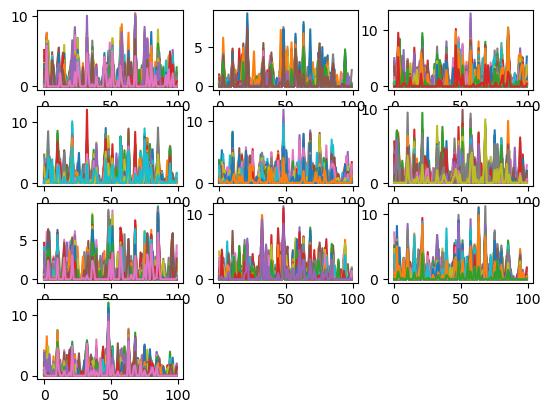

In [9]:
for i in range(10):
    values = np.array(dataset[:1000].query(f'label == {i}').T)   # peak vals
    value = values[1:] # choise image data
    value = value / 255.  # normalize
    plt.subplot(4,3,i+1)
    for j in range(len(value[0])):
        plt.plot(firstLayer(value[:,j,None],w1,b1), label=f'Img{j}')
plt.savefig(f"res\LayerMonitoring_Num{i}_{time.time() / 1000}.jpg")
plt.show()

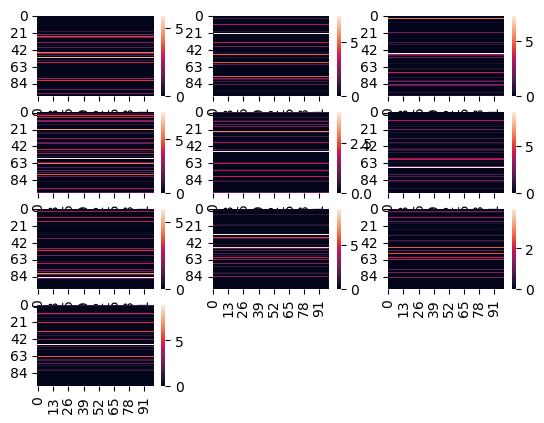

In [10]:
heat = []
firstLayers = []
for k in range(10):
    values = np.array(dataset[:1000].query(f'label == {k}').T)   # peak vals
    value = values[1:] # choise image data
    value = value / 255.  # normalize
    newList1 = []
    plt.subplot(4,3,k+1)
    heat.append([])
    heat[k] = 100 * [0]
    for j in range(len(value[0])):
        firstLayers = firstLayer(value[:,j,None],w1,b1)
    for i in range(len(firstLayers)):
        newList1.append([])
        for j in range(100):
            newList1[i].append(firstLayers[j][0])
            heat[k][j] += firstLayers[j][0]
    sns.heatmap(np.transpose(newList1))
plt.savefig(f"res\LayerMonitoringNodes_Num{k}_{time.time() / 1000}.jpg")
plt.show()

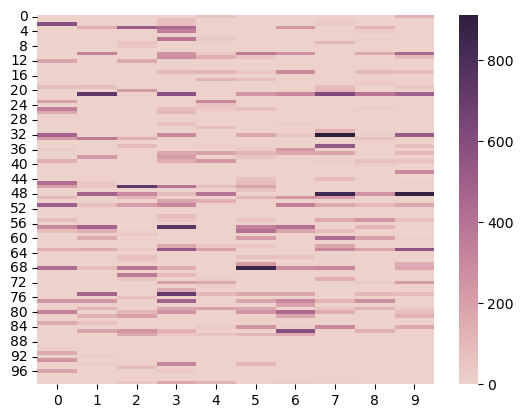

In [11]:
heatSNS = sns.heatmap(np.transpose(heat), cmap=sns.cubehelix_palette(as_cmap=True))
plt.savefig(f"res\LayerMonitoringNodesAcumalator{time.time()}.jpg")
plt.show()

### filter Maxs [Average node Values for each epoch itereition]

In [304]:
numberOfOperate = 9 # each Layer for each number
alpha = 0.4 # HyperParameter filtering threshold 

In [305]:
datas = np.array(dataset[:1000].query(f'label == {numberOfOperate}'))

In [306]:
dataBox = datas.T
numsX = dataBox[1:]
numsY = dataBox[0]
numsX = numsX / 255.

In [307]:
firstLayers = []
for i in range(len(numsX[0])):
    firstLayers.append(ReLU(w1.dot(numsX[:,i,None])+ b1))

In [308]:
newList1 = []
for i in range(len(firstLayers)):
    newList1.append([])
    for j in range(100):
        newList1[i].append(firstLayers[i][j][0])

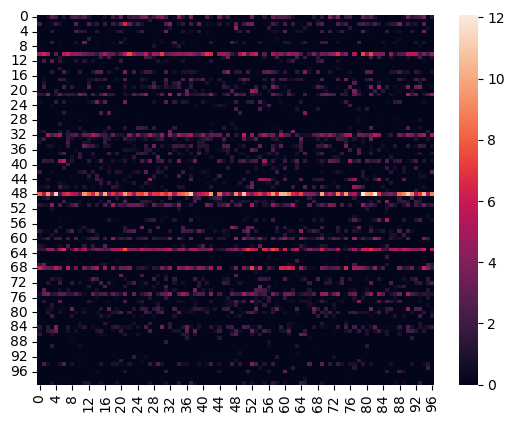

In [309]:
sns.heatmap(np.transpose(newList1))
plt.savefig(f"res\REV_LayerNodeMonitoring_{numberOfOperate}_alpha{alpha}_{time.time()}.jpg")
plt.show()

In [310]:
FirstLayerMean = []
for i in range(100):
    FirstLayerMean.append(np.mean(np.transpose(newList1)[i]))

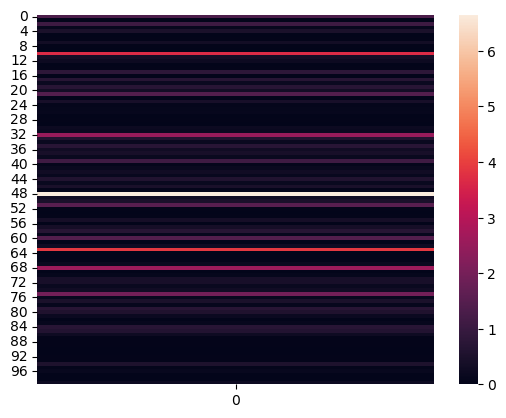

In [311]:
sns.heatmap(np.transpose((FirstLayerMean,)))
plt.savefig(f"res\REV_LayerNodeMonitoringAverage_{numberOfOperate}_alpha{alpha}_{time.time()}.jpg")
plt.show()

In [312]:
for i in range(len(FirstLayerMean)):
    if FirstLayerMean[i] < max(FirstLayerMean)*alpha : 
        FirstLayerMean[i] = 0

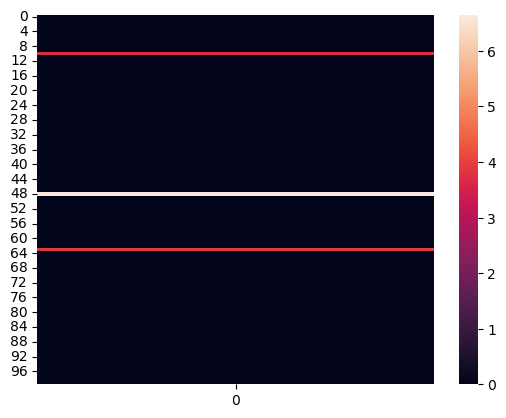

In [313]:
sns.heatmap(np.transpose((FirstLayerMean,)))
plt.savefig(f"res\REV_LayerNodeMonitoringAverage_{numberOfOperate}\
    _alpha{alpha}_AfterFiltering_{time.time()}.jpg")
plt.show()

In [314]:
rvW1AfterFiltering = w1.copy()

In [315]:
numOfParams = 0
for i in range(rvW1AfterFiltering.shape[0]):
    if FirstLayerMean[i] == 0 :
        rvW1AfterFiltering[i] =  np.zeros((1,784)).tolist()[0]
    else :
        numOfParams += len(rvW1AfterFiltering[i])
print(f"Params count : {numOfParams}")

Params count : 2352


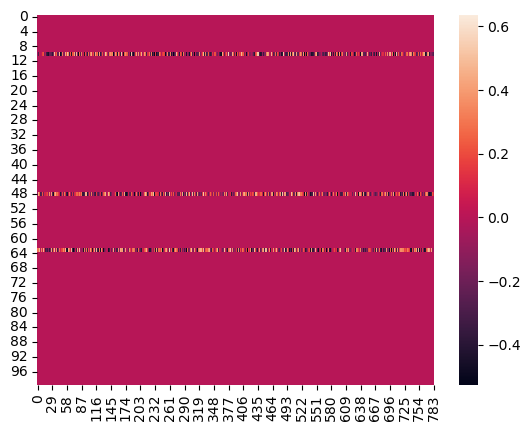

In [316]:
sns.heatmap(rvW1AfterFiltering)
plt.savefig(f"res\REV_LayerNodeMonitoringAverage_ \
            {numberOfOperate}_alpha{alpha}_NewW1AfterFiltering_{time.time()}.jpg")
plt.show()

### Comparison of accuracies

In [317]:
truesAfter = 0
truesBefor = 0
for pr in range(len(numsY)):
    if numsY[pr] == np.argmax(softmax(w2.dot(ReLU(rvW1AfterFiltering.dot(numsX[:,pr ,None])+ b1)) + b2)):
        truesAfter += 1
    if numsY[pr] == np.argmax(softmax(w2.dot(ReLU(w1.dot(numsX[:,pr ,None])+ b1)) + b2)):
        truesBefor += 1
print("Befor Filter Acc : " , truesBefor / len(numsY))
print("After Filter Acc : " , truesAfter / len(numsY))

Befor Filter Acc :  0.7938144329896907
After Filter Acc :  1.0


### Save Special Weights

- #### basic Save Weights to json file

In [318]:
res = {
	"w1": rvW1AfterFiltering.tolist(),
	"w2": w2.tolist(),
    "b1": b1.tolist(),
	"b2": b2.tolist()
}
json_object = json.dumps(res, indent=4)
with open(f"wgts\simpleMLPSpecial{numberOfOperate}_alpha{alpha}_Wghts.json", "w") as outfile:
	outfile.write(json_object)

- ####  Vectorizer : Save Vector Weights to json file

In [319]:
rvW1AfterFilteringDict = []
for i in range(rvW1AfterFiltering.shape[0]):
    if FirstLayerMean[i] != 0 :
        rvW1AfterFilteringDict.append((i , rvW1AfterFiltering[i].tolist()))

In [320]:
res = {
	"w1": rvW1AfterFilteringDict,
	"w2": w2.tolist(),
    "b1": b1.tolist(),
	"b2": b2.tolist()
}
json_object = json.dumps(res, indent=4)
with open(f"wgts\simpleMLPSpecial{numberOfOperate}_alpha{alpha}_WghtsVectorized.json", "w") as outfile:
	outfile.write(json_object)

### Integeration Weights

- #### simple weights

In [321]:
w1 = np.zeros((100,784))
for i in range(10):
    with open(f"wgts\simpleMLPSpecial{i}_alpha{alpha}_Wghts.json", "r") as openfile:
        json_object = json.load(openfile)
    tmpw1 = np.array(json_object['w1'])
    for j in range(len(tmpw1)):
        if sum(w1[j]) == 0:
            w1[j] = tmpw1[j]

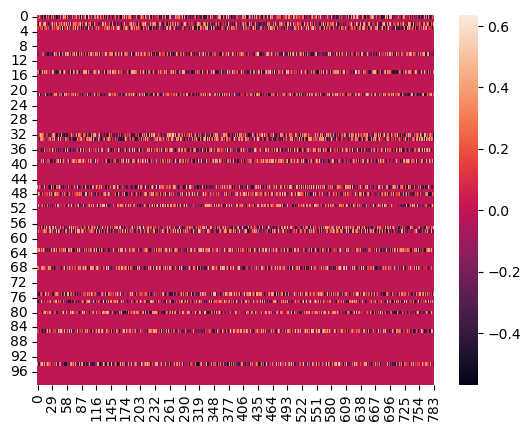

In [322]:
sns.heatmap(w1)
plt.savefig(f"res\REV_LayerNodeMonitoringAverageFinalWghts_ \
            {numberOfOperate}_alpha{alpha}_NewW1AfterFiltering_{time.time()/1000}_Accms.jpg")
plt.show()

- #### vectorized weights

In [323]:
w1 = np.zeros((100,784))
for i in range(10):
    with open(f"wgts\simpleMLPSpecial{i}_alpha{alpha}_WghtsVectorized.json", 'r') as openfile:
        json_object = json.load(openfile)
    for j in range(len(json_object['w1'])):
        if sum(w1[json_object['w1'][j][0]]) == 0:
            w1[json_object['w1'][j][0]] = json_object['w1'][j][1]

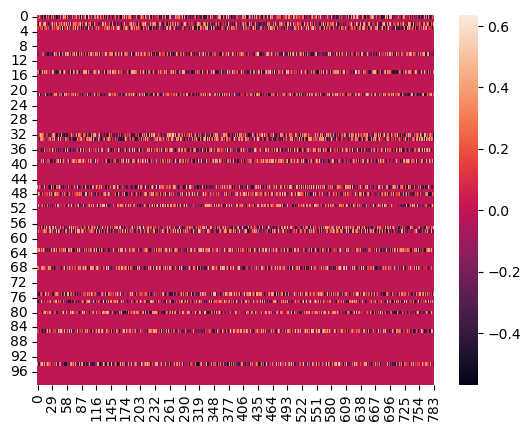

In [324]:
sns.heatmap(w1)
plt.savefig(f"res\REV_LayerNodeMonitoringAverageFinalWghts_ \
            {numberOfOperate}_alpha{alpha}_NewW1AfterFiltering_{time.time()/1000}_Accms.jpg")
plt.show()

### Save comprased weights

- #### Save Simple comprased weights

In [325]:
res = {
	"w1": w1.tolist(),
	"w2": w2.tolist(),
    "b1": b1.tolist(),
	"b2": b2.tolist()
}
json_object = json.dumps(res, indent=4)
with open(f"wgts\simpleMLPFinalComprased_alpha{alpha}.json", "w") as outfile:
	outfile.write(json_object)

- #### Save vectorized comprased weights

In [326]:
rvW1AfterFilteringDict = []
for i in range(w1.shape[0]):
    if sum(w1[i]) != 0 :
        rvW1AfterFilteringDict.append((i , w1[i].tolist()))

In [327]:
res = {
	"w1": rvW1AfterFilteringDict,
	"w2": w2.tolist(),
    "b1": b1.tolist(),
	"b2": b2.tolist()
}
json_object = json.dumps(res, indent=4)
with open(f"wgts\simpleMLPFinalComprasedWghtsVectorized_alpha{alpha}.json", "w") as outfile:
	outfile.write(json_object)

### accuracy for each number : 

In [328]:
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

#### Load comprased weights

- ##### Load Simple comprased weights

In [329]:
with open(f"wgts\simpleMLPFinalComprased_alpha{alpha}.json", "r") as openfile:
    json_object = json.load(openfile)
w1 = np.array(json_object['w1'])
w2 = np.array(json_object['w2'])
b1 = np.array(json_object['b1'])
b2 = np.array(json_object['b2'])

In [330]:
for i in range(10):
    values = np.array(dataset[:1000].query(f'label == {i}').T)   # peak vals
    valueY = values[0]
    valueX = values[1:] # choise image data
    valueX = valueX / 255.  # normalize
    print(f"Accuracy {i} : ",get_accuracy(np.argmax(softmax(w2.dot(ReLU(w1.dot(valueX) + b1)) + b2),0), valueY))

Accuracy 0 :  0.8130841121495327
Accuracy 1 :  0.8020833333333334
Accuracy 2 :  0.8145161290322581
Accuracy 3 :  0.8333333333333334
Accuracy 4 :  0.0392156862745098
Accuracy 5 :  0.6741573033707865
Accuracy 6 :  0.7216494845360825
Accuracy 7 :  0.5523809523809524
Accuracy 8 :  0.7526881720430108
Accuracy 9 :  0.9278350515463918


- ##### Load Vectorized comprased weights

In [331]:
with open(f"wgts\simpleMLPFinalComprasedWghtsVectorized_alpha{alpha}.json","r") as openfile:
    json_object = json.load(openfile)
tmpw1 = json_object['w1']
w2 = np.array(json_object['w2'])
b1 = np.array(json_object['b1'])
b2 = np.array(json_object['b2'])

In [332]:
w1 = np.zeros((100,784))
for i in range(len(tmpw1)):
    w1[tmpw1[i][0]] = tmpw1[i][1]

In [333]:
for i in range(10):
    values = np.array(dataset[:1000].query(f'label == {i}').T)   # peak vals
    valueY = values[0]
    valueX = values[1:] # choise image data
    valueX = valueX / 255.  # normalize
    print(f"Accuracy {i} : ",get_accuracy(np.argmax(softmax(w2.dot(ReLU(w1.dot(valueX) + b1)) + b2),0), valueY))

Accuracy 0 :  0.8130841121495327
Accuracy 1 :  0.8020833333333334
Accuracy 2 :  0.8145161290322581
Accuracy 3 :  0.8333333333333334
Accuracy 4 :  0.0392156862745098
Accuracy 5 :  0.6741573033707865
Accuracy 6 :  0.7216494845360825
Accuracy 7 :  0.5523809523809524
Accuracy 8 :  0.7526881720430108
Accuracy 9 :  0.9278350515463918
